# Example Regression: Database Friedman

In this example it will show how to work the library **deepensemble**. 

## Data

In this regression problem the data are generated from the following function:
$$
h_F(\textbf{x}) = 10 sin (\pi x_1 x_2) + 20 \left(x_3 - \frac{1}{2} \right)^2 + 10x_4 + 5x_5,
$$
where $\textbf{x} = [x_1, ..., x_{10}]$ is the input vector and each component of it is obtained as the value of a random variable of uniform distribution in the interval $[0, 1]$. Although the input vector of the function has 10 elements, only the first 5 elements are used, therefore, there are 5 irrelevant characteristics and therefore it is expected that the models to be trained discard these values.

In [5]:
from config_test import *

from theano import config
from sklearn import model_selection
from matplotlib.pyplot import *
from theano import shared, config
import numpy as np

from deepensemble.metrics import *
from deepensemble.utils import *

N = 1000

X, y = friendman(sample_len=N, seed=42)
y = np.array(y[:, np.newaxis], dtype=config.floatX)
X = np.array(X, dtype=config.floatX)
t = np.arange(N)

# Added Noise
s_noise = 0.01
nu = np.random.randn(N, 1) * s_noise
# nu[np.random.rand(N,1) > 0.95] += 0.2

z = y

n_train = int(N * 0.5)
i_test = N - n_train

y_train = z[0:n_train]
y_test = z[i_test:N]
X_train = X[0:n_train]
X_test = X[i_test:N]
t_train = t[0:n_train]
t_test = t[i_test:N]

fx_train = y[0:n_train]
fx_test = y[i_test:N]

## Plot database

<IPython.core.display.Javascript object>


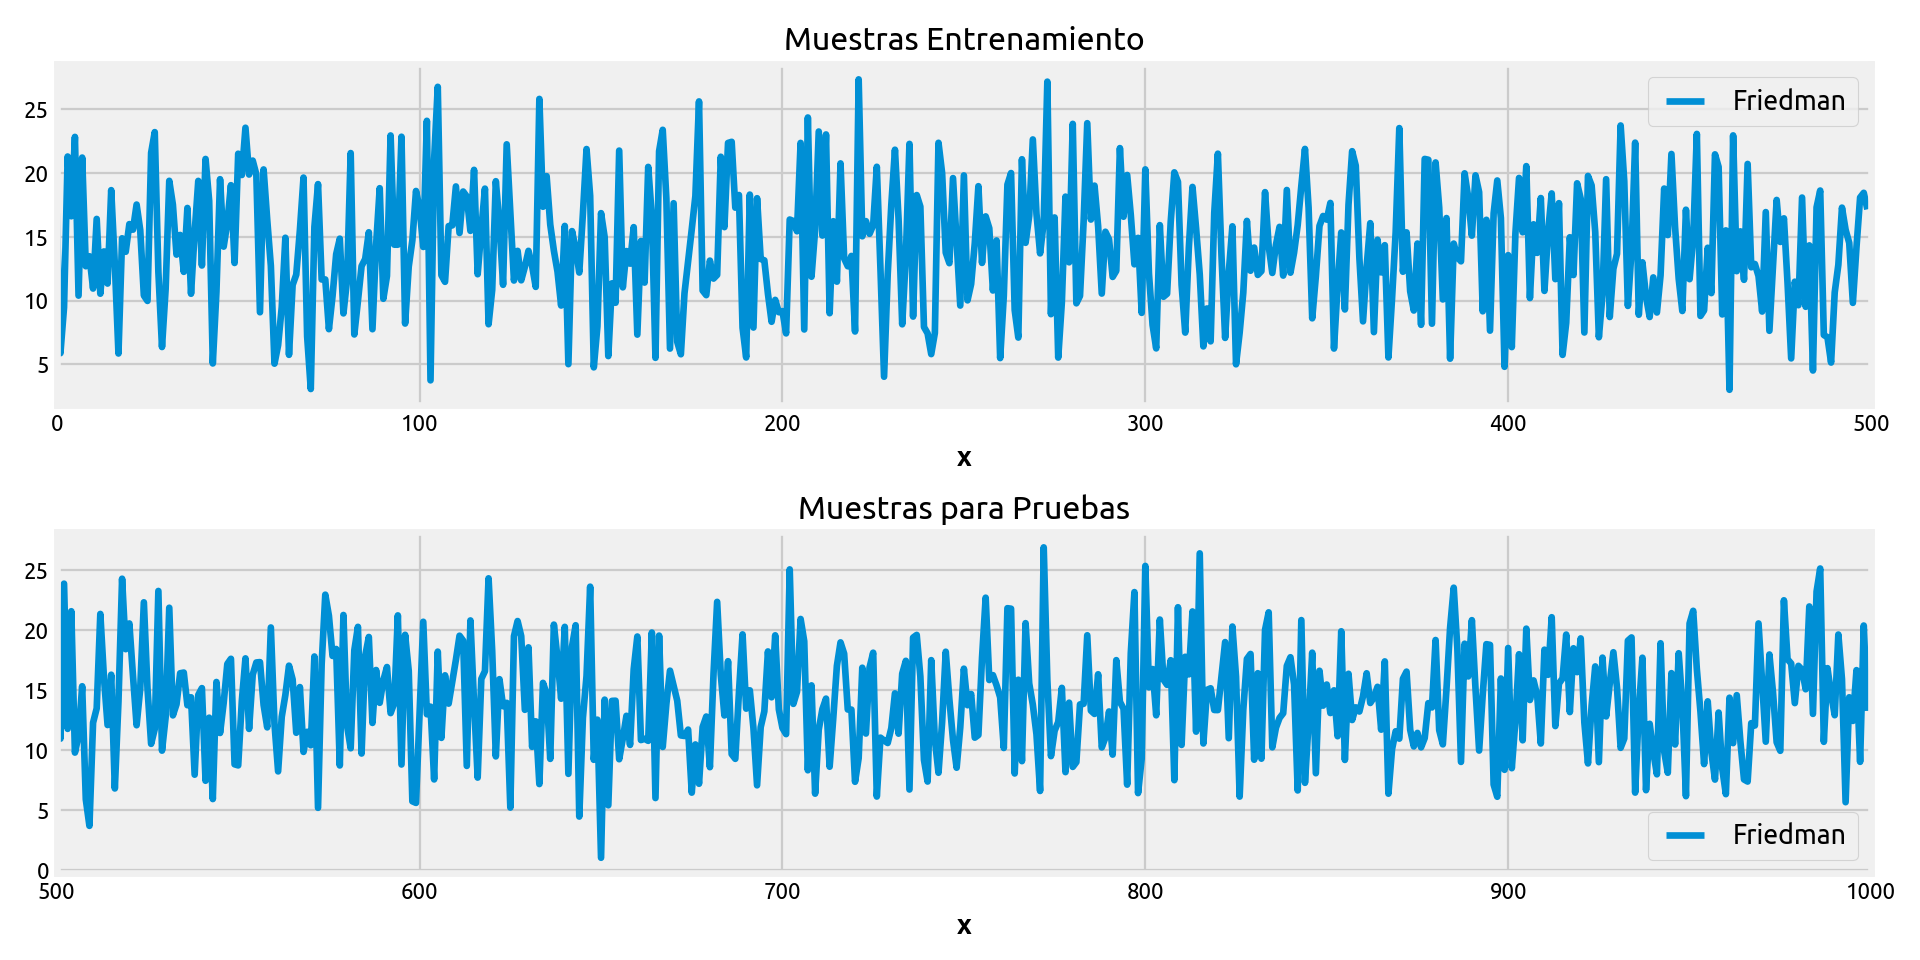

In [6]:
from matplotlib.pyplot import *
%matplotlib notebook

import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

fig = plt.figure(figsize=(12, 6), dpi=80)
ConfigPlot().set_size_font(10)

ax = plt.subplot(211)
ax.plot(t_train, fx_train, '-', lw=3, label='Friedman')
plt.title('Muestras Entrenamiento')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.xlim([0, 500])
plt.tight_layout()

ax = plt.subplot(212)
ax.plot(t_test, fx_test, '-', lw=3, label='Friedman')
plt.title('Muestras para Pruebas')
plt.xlabel('x')
plt.legend(loc='best', numpoints=3)
plt.xlim([500, 1000])
plt.tight_layout()

## Configure model parameters 

In [7]:
n_neurons = 15
n_models = 4
lr = 0.1
batch_size = 40
max_epoch = 500

n_ensemble_models = 4

fn_activation1 = ActivationFunctions.tanh
fn_activation2 = ActivationFunctions.linear

n_features = X_train.shape[1]

n_output = y_train.shape[1]
n_inputs = n_features

n_neurons_model = int(0.75 * (n_output + n_inputs))

s = ITLFunctions.silverman(np.array(y_train)).eval()
print('Silverman: %0.4g' % s)

args_train_default = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True}

args_train_cip = {'max_epoch': max_epoch, 'batch_size': batch_size, 'early_stop': False,
              'improvement_threshold': 0.995, 'update_sets': True, 'minibatch': True,
              'criterion_update_params': 'cost', 'maximization_criterion': True}

Silverman: 1.498


## Training MLP MSE

This MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [8]:
# Create MLP
mlp = get_mlp_model("MLP MSE",
                    n_input=n_features, n_output=n_output,
                    n_neurons=n_neurons_model,
                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                    cost=mse, name_cost="MSE", params_update={'learning_rate': lr})

metrics_mlp = FactoryMetrics.get_metric(mlp)

# Compile
mlp.compile(fast=True)
                      
# training
metrics = mlp.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_mlp.append_metric(metrics)

Comienza la compilación MLP MSE  - elapsed: 0.19 [s]
MLP MSE - fold: 1, epoch:[####################] 500/500 elapsed: 1.07[s] - left: 0.00[s] | score: 3.1154 / 5.96175
FINISHED!


## Training Ensemble MSE

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **MSE** and the update funtion is **SGD** (learning rate $\eta=${{lr}}).

In [9]:
# Create Ensemble
ensemble = get_ensemble_model(name='Ensamble MSE',
                                  n_input=n_features, n_output=n_output,
                                  n_ensemble_models=n_ensemble_models, n_neurons_model=n_neurons_model,
                                  fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                  cost=mse, name_cost="MSE",
                                  params_update={'learning_rate': lr})

metrics_ensemble = FactoryMetrics.get_metric(ensemble)

# Compile
ensemble.compile(fast=True)

# training
metrics = ensemble.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensemble.append_metric(metrics)

Comienza la compilación Ensamble MSE  - elapsed: 0.85 [s]
Ensamble MSE - fold: 1, epoch:[####################] 500/500 elapsed: 2.14[s] - left: 0.00[s] | score: 2.2038 / 4.68363
FINISHED!


## Training Ensemble NCL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **NCL** (Negative Correlation Learning) and the update funtion is **SGD** (learning rate $\eta=${{lr}}). The parameter of **NCL** is $\lambda=0.4$.

In [10]:
# Create Ensemble NCL
ensembleNCL = get_ensembleNCL_model(name='Ensamble NCL',
                                        n_input=n_features, n_output=n_output,
                                        n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                        fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                        lamb=0.4, params_update={'learning_rate': lr})

metrics_ensembleNCL = FactoryMetrics.get_metric(ensembleNCL)

# Compile
ensembleNCL.compile(fast=True)
                      
# training
metrics = ensembleNCL.fit(X_train, y_train, **args_train_default)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleNCL.append_metric(metrics)

Comienza la compilación Ensamble NCL  - elapsed: 3.19 [s]
Ensamble NCL - fold: 1, epoch:[####################] 500/500 elapsed: 3.98[s] - left: 0.00[s] | score: 2.0095 / 5.19021
FINISHED!


## Training Ensemble CIPL

This ensemble has {{n_ensemble_models}} MLP networks, where each MLP net has {{n_neurons_model}} neurons in hidden layer. The cost function is **CIPL** (Cross Informartion Potential Learning) and the update funtion is **SGD** (learning rate $\eta=-0.1$). The parameters of **CIPL** are $\beta=0.1$ and $\lambda=0.1$.

In [111]:
# Create Ensemble CIP
ensembleCIP = get_ensembleCIP_model(name='Ensamble CIPL',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=0.1, lamb=0.1, s=s,
                                    lsp=1.5, lsm=0.5,
                                    lr=0.02,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.1})

metrics_ensembleCIP = FactoryMetrics.get_metric(ensembleCIP)

# Compile
ensembleCIP.compile(fast=False)
                      
# training
metrics = ensembleCIP.fit(X_train, y_train, **args_train_cip)
print("FINISHED!")

# Compute metricstrain
metrics_ensembleCIP.append_metric(metrics)

Comienza la compilación Ensamble CIPL  - elapsed: 17.56 [s]
Ensamble CIPL - fold: 1, epoch:[####################] 500/500 elapsed: 16.18[s] - left: 0.00[s] | score: 2.0190 / 3.7981
FINISHED!


<IPython.core.display.Javascript object>


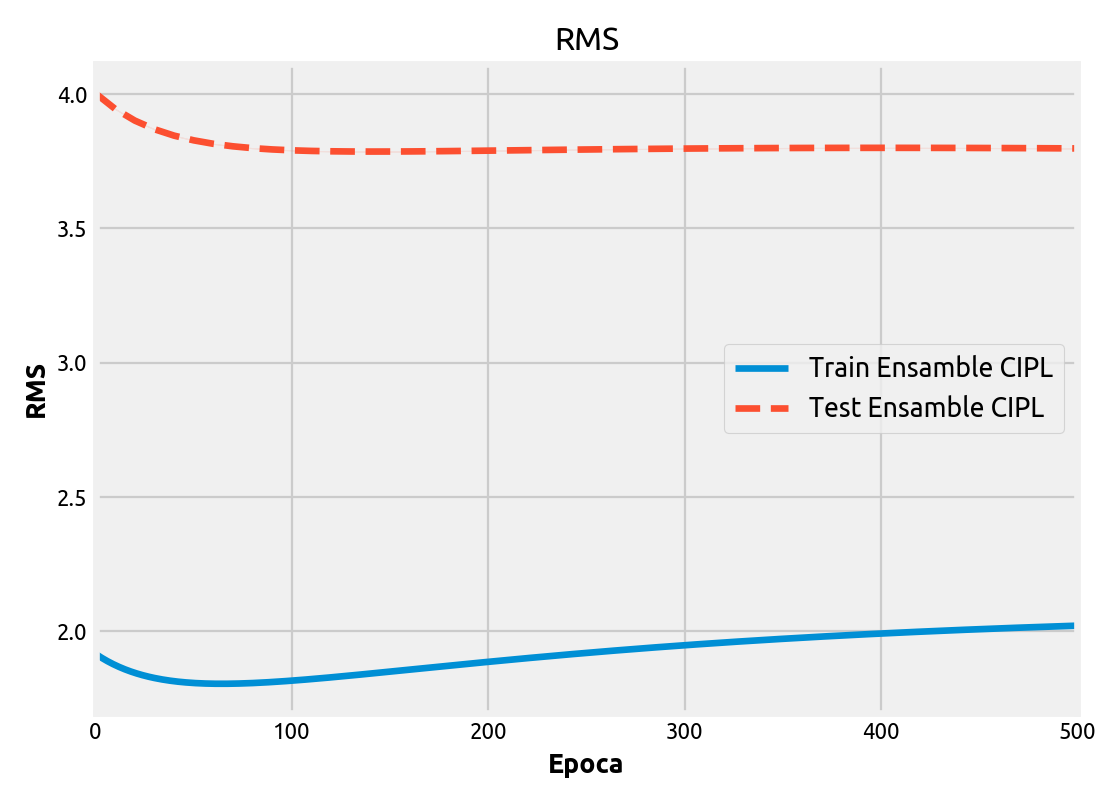

<IPython.core.display.Javascript object>


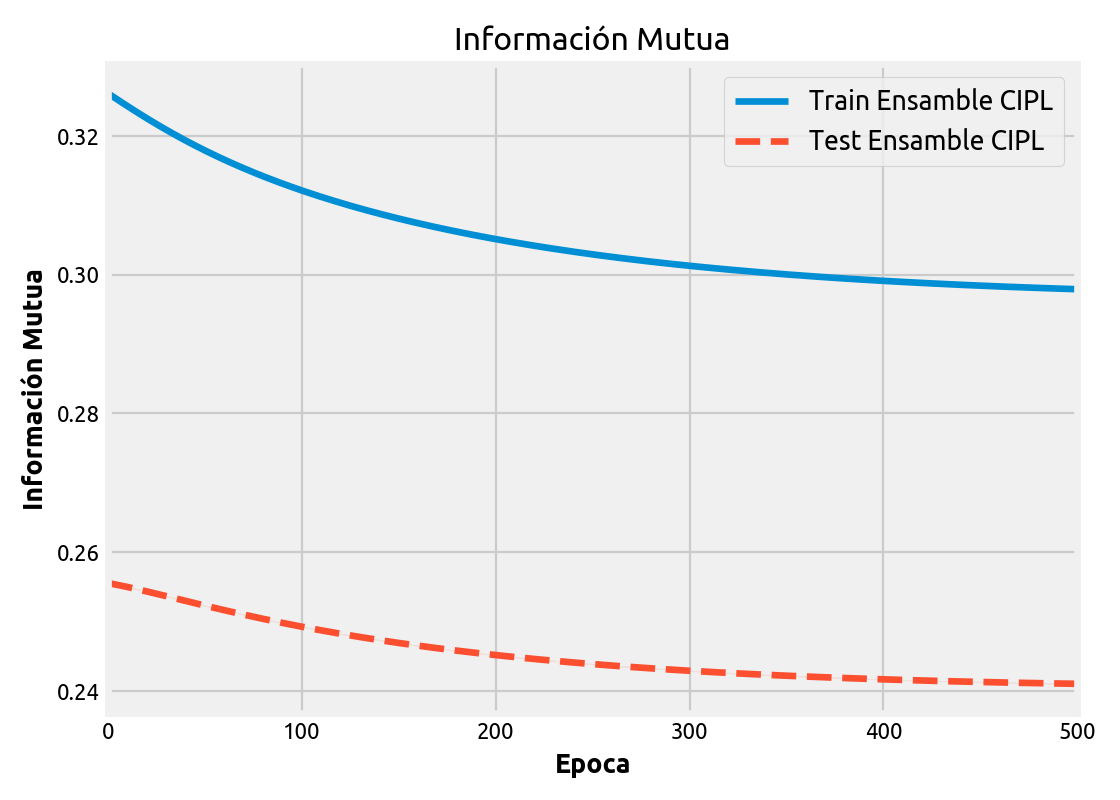

<IPython.core.display.Javascript object>


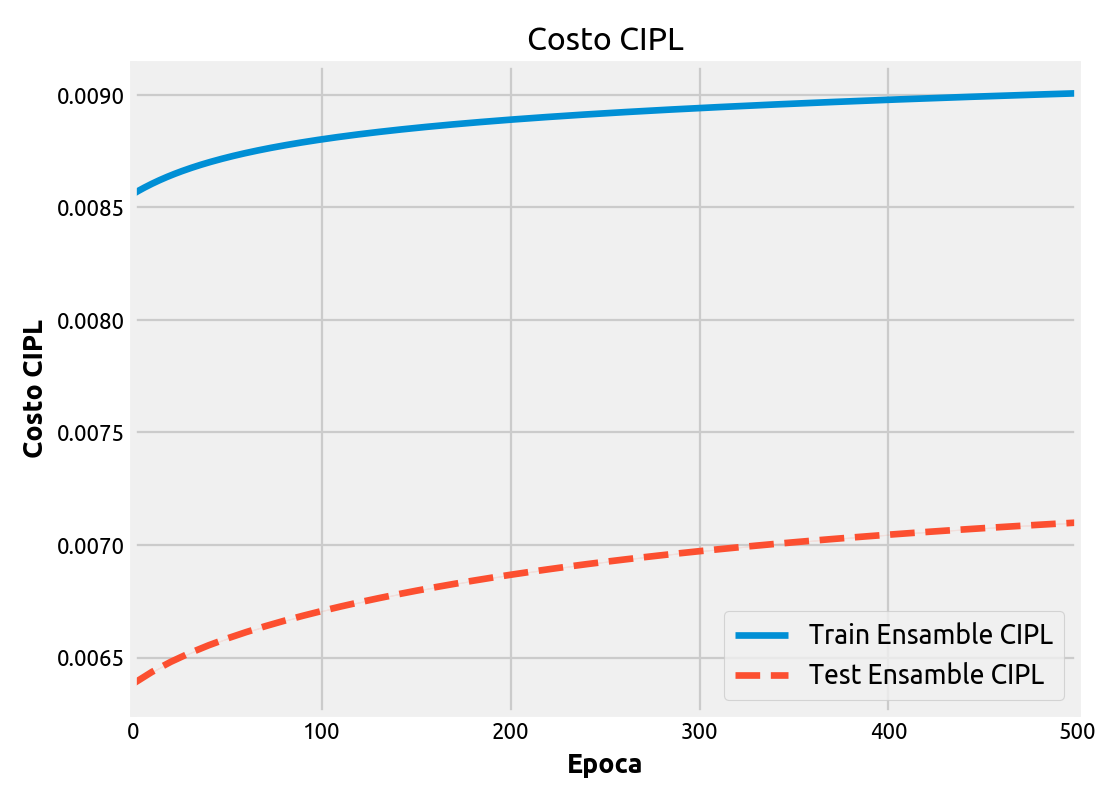

In [112]:
ConfigPlot().set_size_font(10)
ConfigPlot().set_dpi(80)
ConfigPlot().set_hold(False)
ConfigPlot().set_fig_size((7, 5))

metrics_ensembleCIP.plot_scores(max_epoch=max_epoch, title='')
metrics_ensembleCIP.plot_cost(max_epoch=max_epoch, title='Costo CIPL')

plt.show()

## Summary model training

<IPython.core.display.Javascript object>


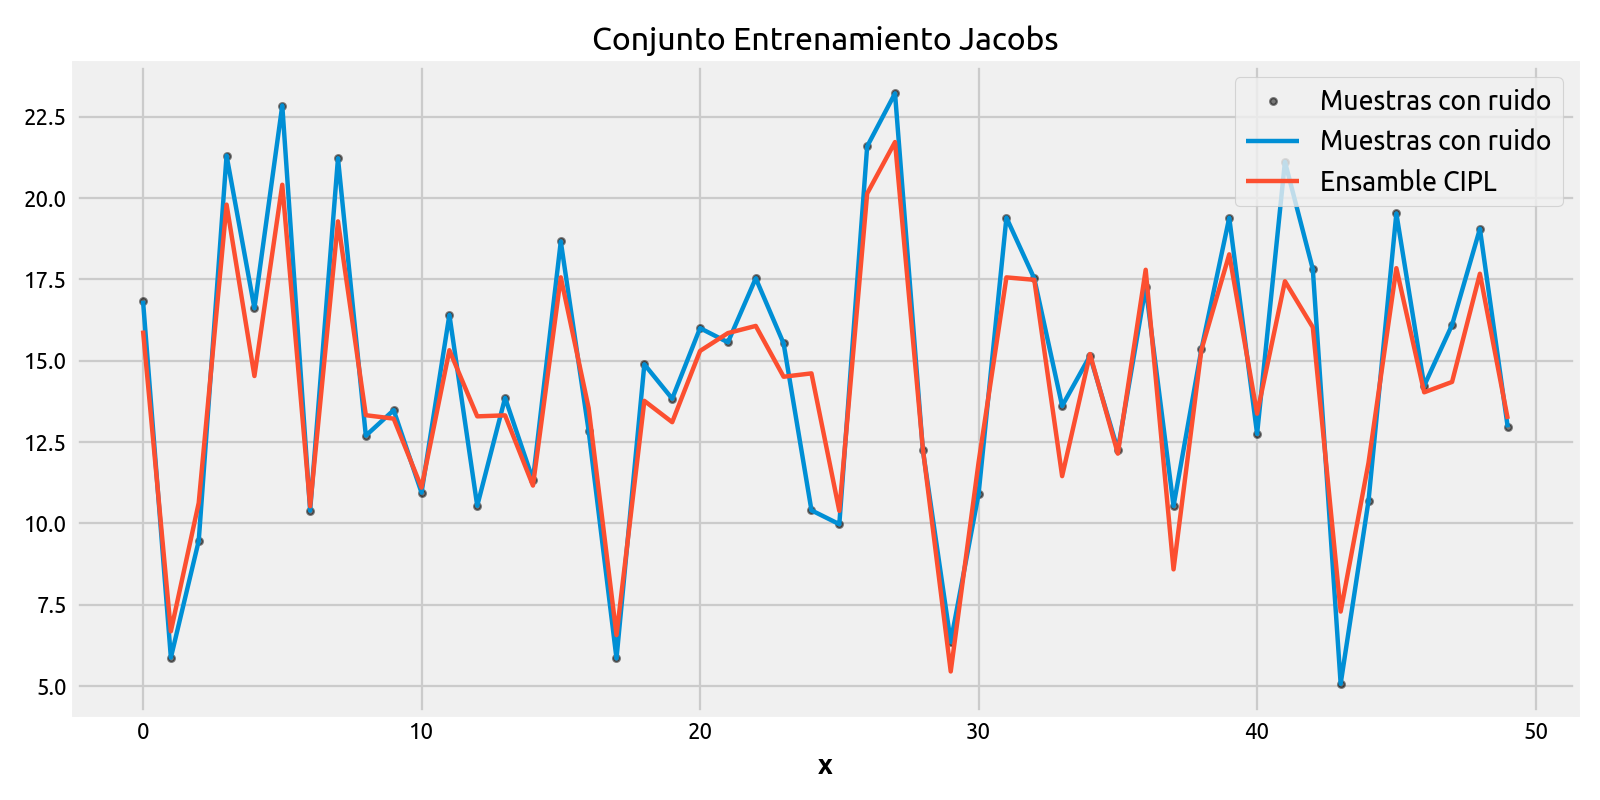

<IPython.core.display.Javascript object>


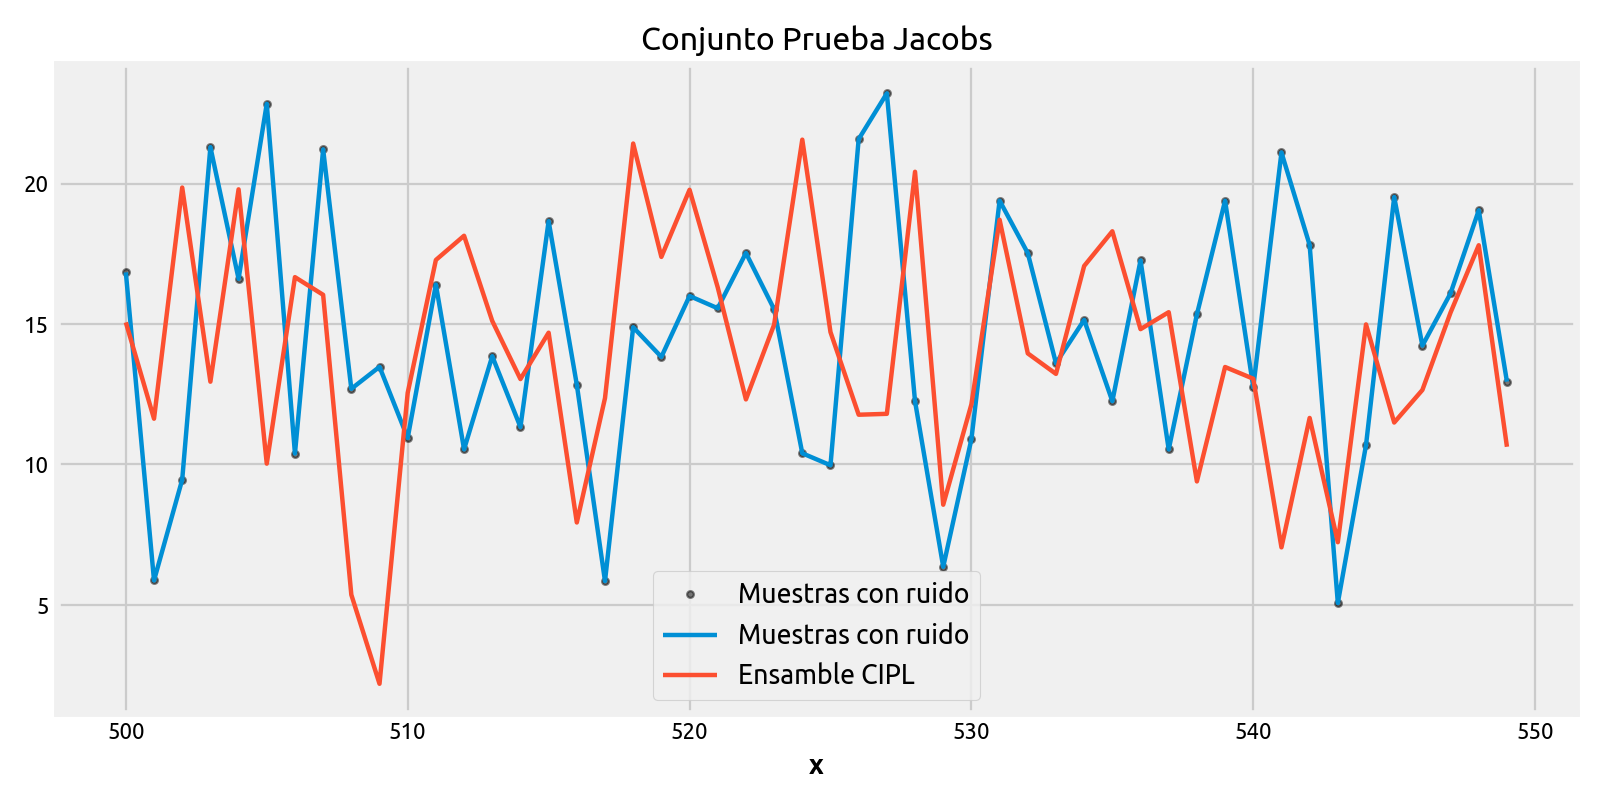

In [113]:
fig = plt.figure(figsize=(10, 5), dpi=80)

nm = 50

plt.plot(t_train[0:nm], z[0:nm], 'k.', alpha=0.5,  label='Muestras con ruido')
plt.plot(t_train[0:nm], y[0:nm], lw=2, label='Muestras con ruido')
plt.plot(t_train[0:nm], ensembleCIP.predict(X_train[0:nm]), lw=2, label='Ensamble CIPL')
plt.title('Conjunto Entrenamiento Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

fig = plt.figure(figsize=(10, 5), dpi=80)

plt.plot(t_test[0:nm], z[0:nm], 'k.', alpha=0.5, label='Muestras con ruido')
plt.plot(t_test[0:nm], y[0:nm], lw=2,label='Muestras con ruido')
plt.plot(t_test[0:nm], ensembleCIP.predict(X_test[0:nm]), lw=2, label='Ensamble CIPL')
plt.title('Conjunto Prueba Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [114]:
score_test_ensemble = ensemble.score(X_test, y_test)
score_train_ensemble = ensemble.score(X_train, y_train)

score_test_ensembleNCL = ensembleNCL.score(X_test, y_test)
score_train_ensembleNCL = ensembleNCL.score(X_train, y_train)

score_test_ensembleCIP = ensembleCIP.score(X_test, y_test)
score_train_ensembleCIP = ensembleCIP.score(X_train, y_train)

score_test_mlp = mlp.score(X_test, y_test)
score_train_mlp = mlp.score(X_train, y_train)

print('Score RMS')
print('Ensamble MSE: %f / %f' % (score_train_ensemble, score_test_ensemble))
print('Ensamble NCL: %f / %f' % (score_train_ensembleNCL, score_test_ensembleNCL))
print('Ensamble CIP: %f / %f' % (score_train_ensembleCIP, score_test_ensembleCIP))
print('MLP MSE: %f / %f' % (score_train_mlp, score_test_mlp))

Score RMS
Ensamble MSE: 2.496253 / 3.831092
Ensamble NCL: 2.029328 / 3.414207
Ensamble CIP: 2.210867 / 2.832347
MLP MSE: 3.198543 / 5.311752


<IPython.core.display.Javascript object>


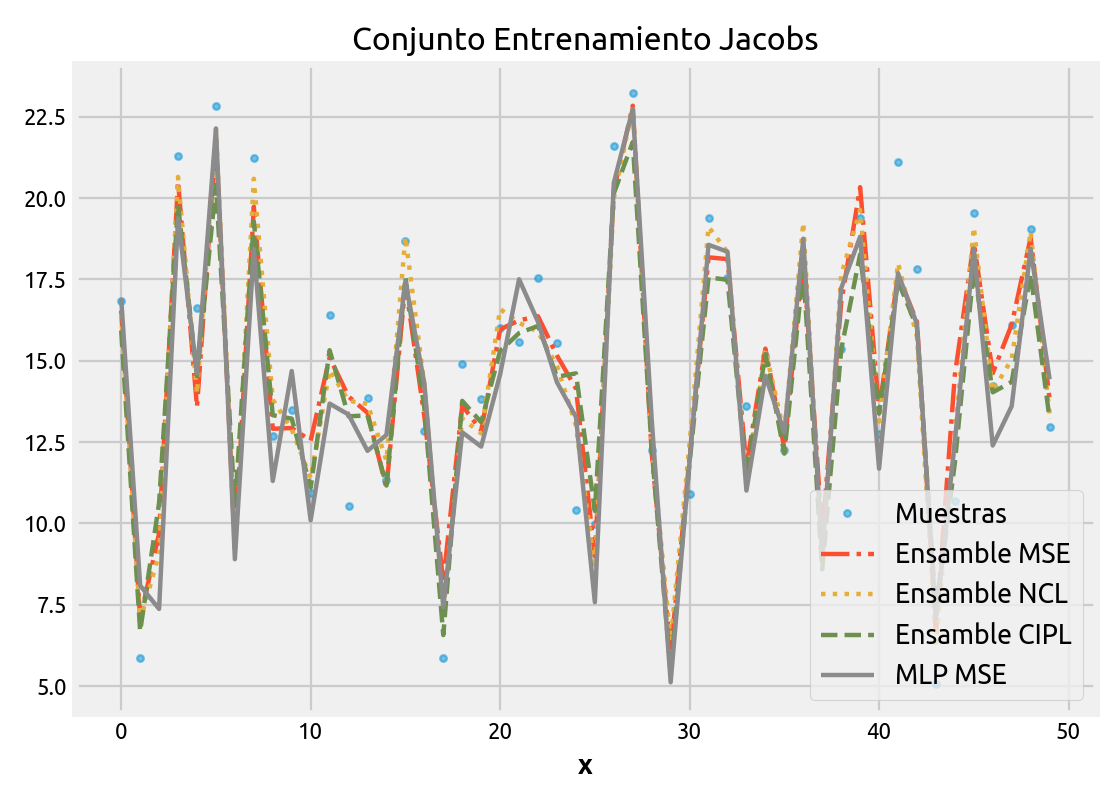

<IPython.core.display.Javascript object>


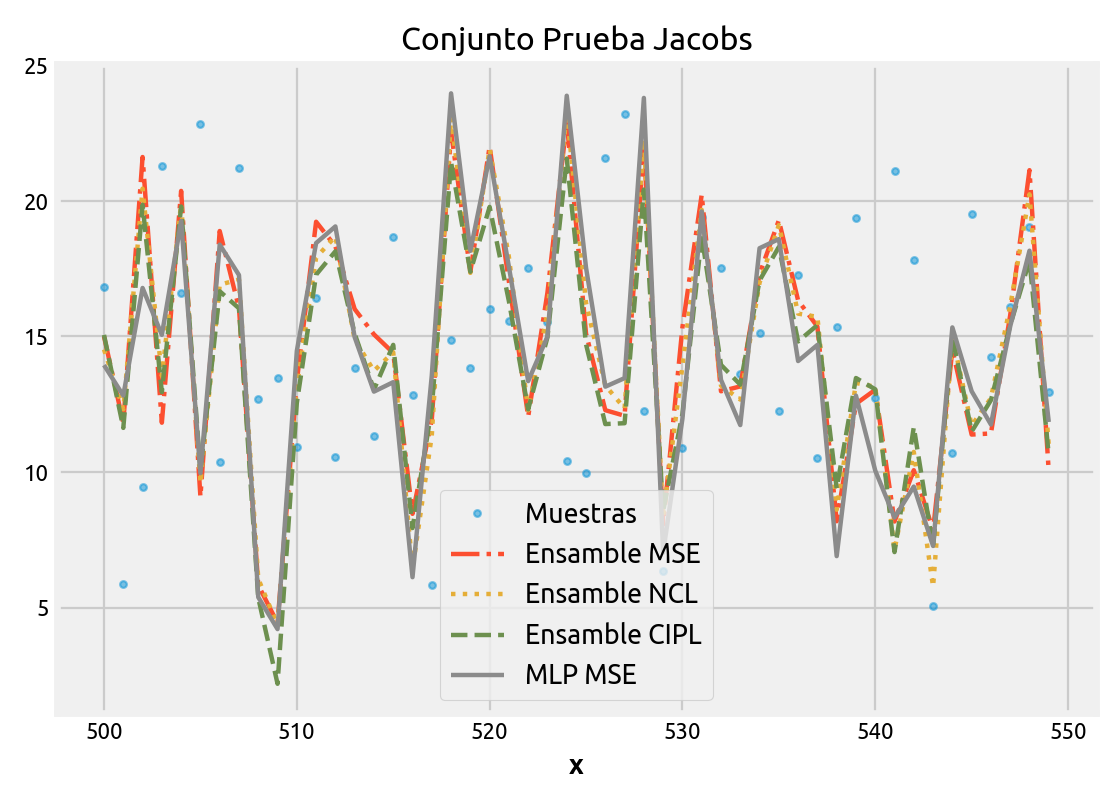

In [115]:
plt.close()

fig = plt.figure(figsize=(7, 5), dpi=80)

nm = 50

plt.plot(t_train[0:nm], z[0:nm], '.', alpha=0.5, label='Muestras')
plt.plot(t_train[0:nm], ensemble.predict(X_train[0:nm]), lw=2, linestyle='-.', label='Ensamble MSE')
plt.plot(t_train[0:nm], ensembleNCL.predict(X_train[0:nm]), lw=2, linestyle=':', label='Ensamble NCL')
plt.plot(t_train[0:nm], ensembleCIP.predict(X_train[0:nm]), lw=2, linestyle='--', label='Ensamble CIPL')
plt.plot(t_train[0:nm], mlp.predict(X_train[0:nm]), lw=2, linestyle='-', label='MLP MSE')
plt.title('Conjunto Entrenamiento Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

fig = plt.figure(figsize=(7, 5), dpi=80)

plt.plot(t_test[0:nm], z[0:nm], '.', alpha=0.5, label='Muestras')
plt.plot(t_test[0:nm], ensemble.predict(X_test[0:nm]), lw=2, linestyle='-.',  label='Ensamble MSE')
plt.plot(t_test[0:nm], ensembleNCL.predict(X_test[0:nm]), lw=2, linestyle=':',  label='Ensamble NCL')
plt.plot(t_test[0:nm], ensembleCIP.predict(X_test[0:nm]), lw=2, linestyle='--',  label='Ensamble CIPL')
plt.plot(t_test[0:nm], mlp.predict(X_test[0:nm]), lw=2, linestyle='-',  label='MLP MSE')
plt.title('Conjunto Prueba Jacobs')
plt.xlabel('x')
plt.legend(loc='best')

plt.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


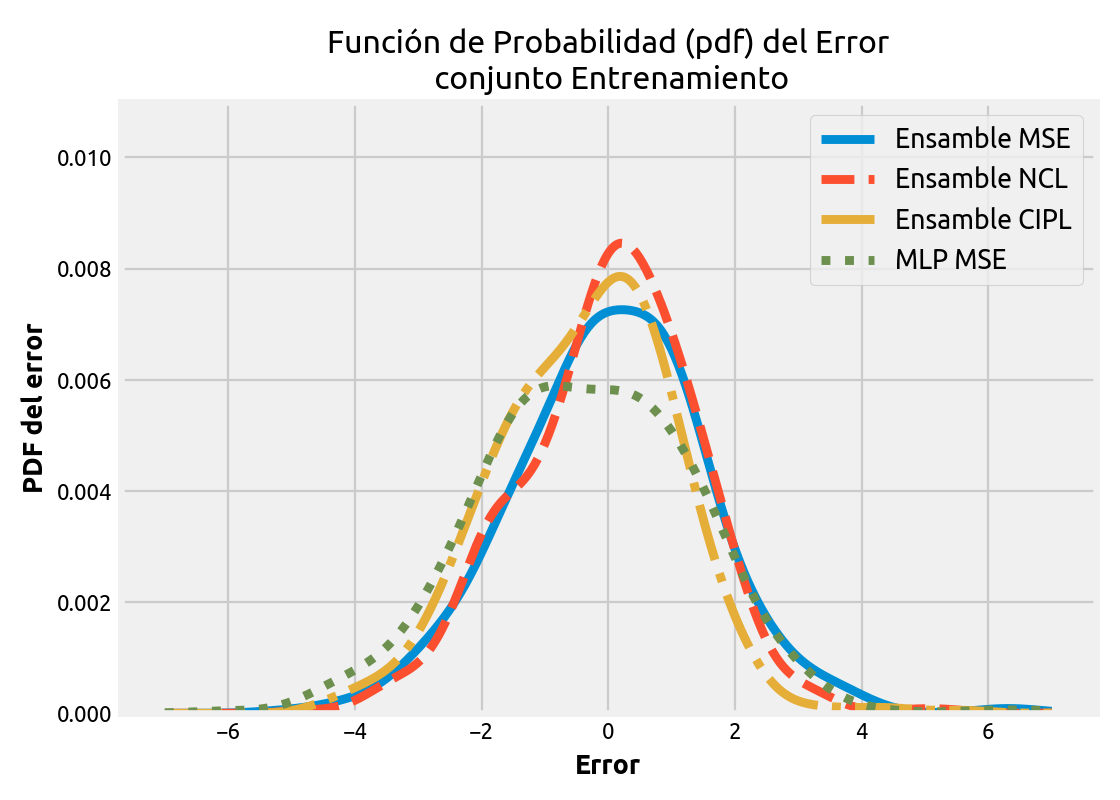

In [116]:
fig = plt.figure(figsize=(7, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error([ensemble, ensembleNCL, ensembleCIP, mlp], X_train, y_train,
               'Función de Probabilidad (pdf) del Error\n conjunto Entrenamiento',
               ax, fig, xmin=-7, xmax=7, lim_y=0.011)

plt.show()

<IPython.core.display.Javascript object>


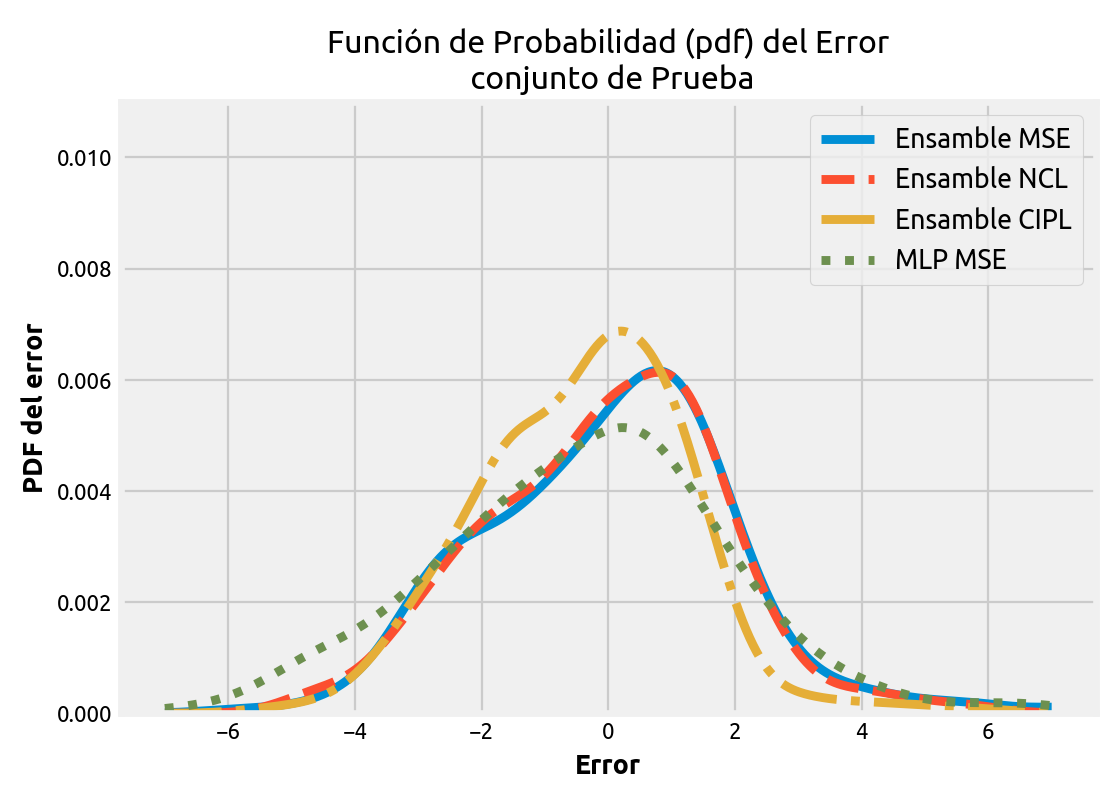

In [117]:
fig = plt.figure(figsize=(7, 5), dpi=80)
ax = fig.add_subplot(1, 1, 1)

plot_pdf_error([ensemble, ensembleNCL, ensembleCIP, mlp], X_test, y_test,
               'Función de Probabilidad (pdf) del Error\n conjunto de Prueba',
               ax, fig, xmin=-7, xmax=7, lim_y=0.011)

plt.show()

In [18]:
def get_ensemble_cip_cs(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lr=0.02,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.5}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_ed(_param, s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=_param, lamb=_param, s=s_sigma,
                                    lr=0.02,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.5}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [71]:
parameters = [n for n in np.linspace(-1, 1, 11)]

score_cs = []
diversity_cs = []
for p in parameters:
    model_cs = get_ensemble_cip_cs(p, s)
    Logger().log_disable()
    divty = []
    score = []
    for i in range(5):
        metric = model_cs.fit(X_train, y_train, **args_train_cip)
        metric.append_prediction(X_test, y_test, append_last_pred=True)
        score.append(model_cs.score(X_test, y_test))
        divty.append(metric.get_diversity(metric=ambiguity)[0])
        model_cs.reset()
    
    score_cs.append( [np.mean(score), np.std(score)] )
    diversity_cs.append( [np.mean(divty), np.std(divty)] )

Comienza la compilación Ensamble CIPL CS  - elapsed: 14.35 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 15.54 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 13.24 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 17.01 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 14.80 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 2.23 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 17.52 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 13.78 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.40 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.29 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 15.55 [s]


In [72]:
score_ed = []
diversity_ed = []
for p in parameters:
    model_ed = get_ensemble_cip_ed(p, s)
    Logger().log_disable()
    divty = []
    score = []
    for i in range(5):
        metric = model_ed.fit(X_train, y_train, **args_train_cip)
        metric.append_prediction(X_test, y_test, append_last_pred=True)
        score.append(model_ed.score(X_test, y_test))
        divty.append(metric.get_diversity(metric=ambiguity)[0])
        model_ed.reset()
    
    score_ed.append( [np.mean(score), np.std(score)] )
    diversity_ed.append( [np.mean(divty), np.std(divty)]  )

Comienza la compilación Ensamble CIPL ED  - elapsed: 12.16 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 14.68 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 15.73 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 12.93 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 15.74 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 1.69 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 16.16 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 13.38 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 14.28 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 17.12 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 14.49 [s]


<IPython.core.display.Javascript object>


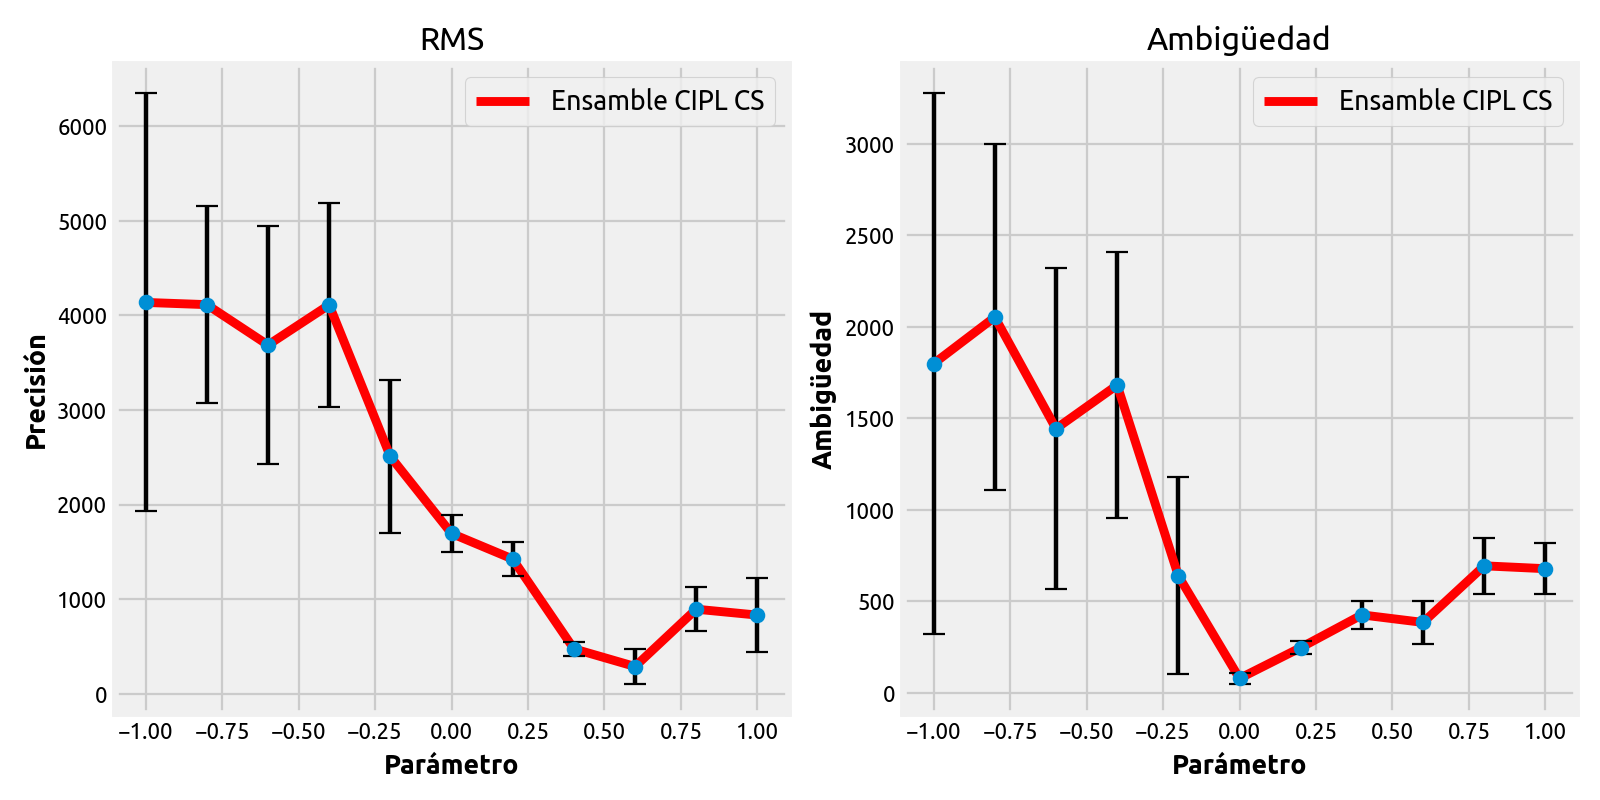

<IPython.core.display.Javascript object>


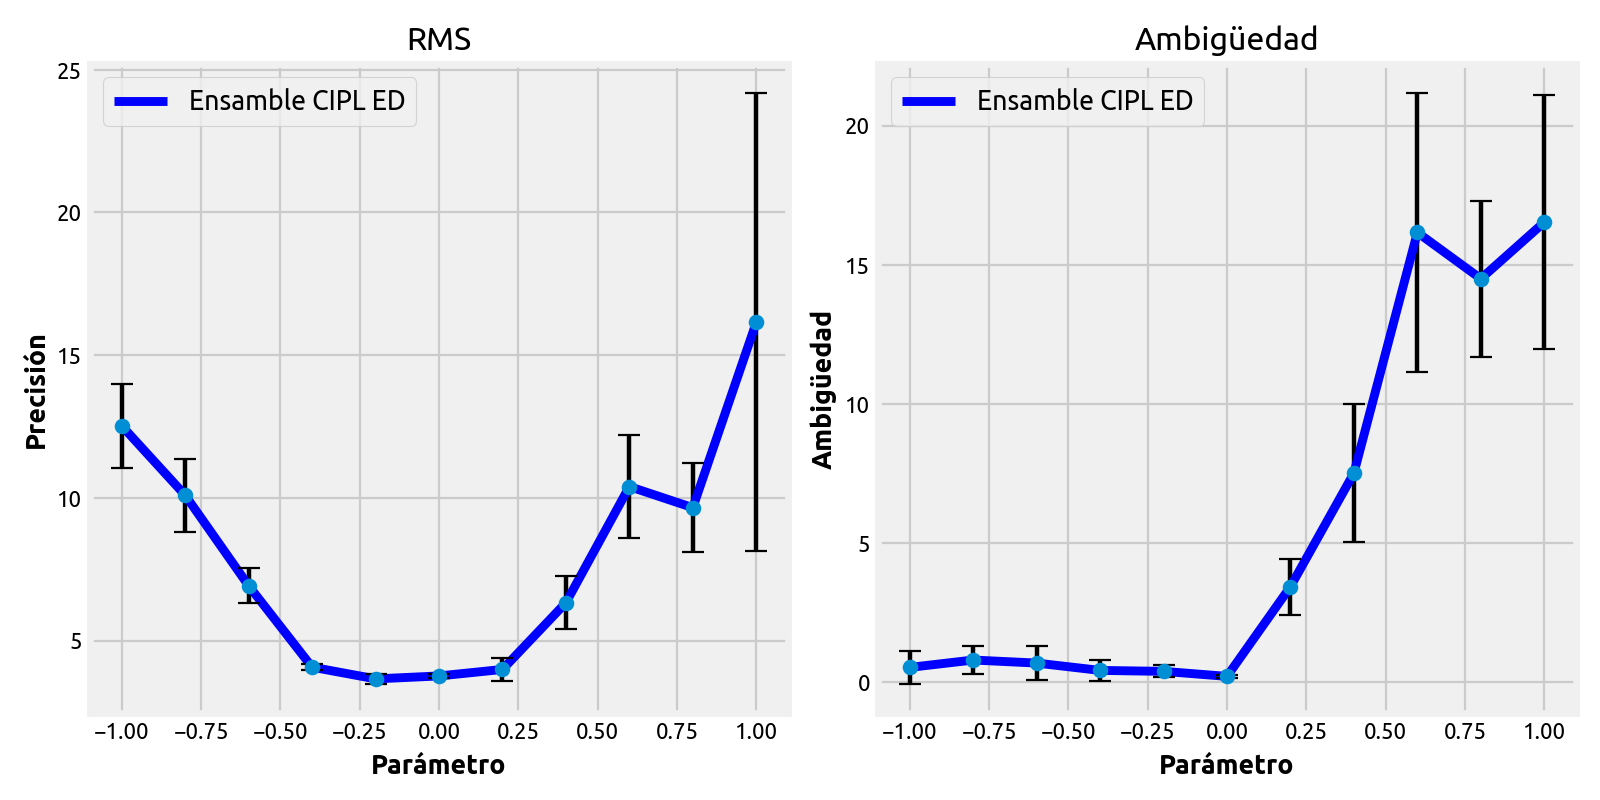

In [84]:
score_cs = np.array(score_cs)
diversity_cs = np.array(diversity_cs)
score_ed = np.array(score_ed)
diversity_ed = np.array(diversity_ed)

f = plt.figure(figsize=(10,5), dpi=80)
plt.subplot(121)
plt.plot(parameters, score_cs[:, 0], '-r', label='Ensamble CIPL CS')
plt.errorbar(parameters, score_cs[:, 0], score_cs[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('RMS')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')
plt.subplot(122)
plt.plot(parameters, diversity_cs[:, 0], '-r', label='Ensamble CIPL CS')
plt.errorbar(parameters, diversity_cs[:, 0], diversity_cs[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Ambigüedad')
plt.xlabel('Parámetro')
plt.ylabel('Ambigüedad')
plt.tight_layout()

f = plt.figure(figsize=(10,5), dpi=80)
plt.subplot(121)
plt.plot(parameters, score_ed[:, 0], '-b', label='Ensamble CIPL ED')
plt.errorbar(parameters, score_ed[:, 0], score_ed[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('RMS')
plt.xlabel('Parámetro')
plt.ylabel('Precisión')
plt.subplot(122)
plt.plot(parameters, diversity_ed[:, 0], '-b', label='Ensamble CIPL ED')
plt.errorbar(parameters, diversity_ed[:, 0], diversity_ed[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Ambigüedad')
plt.xlabel('Parámetro')
plt.ylabel('Ambigüedad')

plt.tight_layout()

plt.show()

In [74]:
def get_ensemble_cip_s_cs(s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL CS',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='CS',
                                    beta=0.1, lamb=0.1, s=s_sigma,
                                    lr=0.1,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.1}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

def get_ensemble_cip_s_ed(s_sigma, fast=True):
    ensemble = get_ensembleCIP_model(name='Ensamble CIPL ED',
                                    n_input=n_features, n_output=n_output,
                                    n_ensemble_models=n_ensemble_models, n_neurons_models=n_neurons_model,
                                    is_cip_full=False,
                                    fn_activation1=fn_activation1, fn_activation2=fn_activation2,
                                    dist='ED',
                                    beta=0.1, lamb=0.1, s=s_sigma,
                                    lr=0.1,
                                    bias_layer=False, mse_first_epoch=True, annealing_enable=False,
                                    update=sgd, name_update='SGD',
                                    params_update={'learning_rate': -0.5}
                                    )

    ensemble.compile(fast=fast)

    return ensemble

In [75]:
ns = np.array([0.01, 0.1, 0.5, 1, 2, 10, 100])

sss = s * ns

score_s_cs = []
diversity_s_cs = []
for ss in sss:
    model_cs = get_ensemble_cip_s_cs(ss)
    Logger().log_disable()
    divty = []
    score = []
    for i in range(5):
        metric = model_cs.fit(X_train, y_train, **args_train_cip)
        metric.append_prediction(X_test, y_test, append_last_pred=True)
        score.append(model_cs.score(X_test, y_test))
        divty.append(metric.get_diversity(metric=ambiguity)[0])
        model_cs.reset()
    
    score_s_cs.append( [np.mean(score), np.std(score)] )
    diversity_s_cs.append( [np.mean(divty), np.std(divty)] )

Comienza la compilación Ensamble CIPL CS  - elapsed: 18.43 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 19.36 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 17.76 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 19.84 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 19.31 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 16.67 [s]
Comienza la compilación Ensamble CIPL CS  - elapsed: 19.39 [s]


In [76]:
score_s_ed = []
diversity_s_ed = []
for ss in sss:
    model_ed = get_ensemble_cip_s_ed(ss)
    Logger().log_disable()
    divty = []
    score = []
    for i in range(5):
        metric = model_cs.fit(X_train, y_train, **args_train_cip)
        metric.append_prediction(X_test, y_test, append_last_pred=True)
        score.append(model_ed.score(X_test, y_test))
        divty.append(metric.get_diversity(metric=ambiguity)[0])
        model_ed.reset()
    
    score_s_ed.append( [np.mean(score), np.std(score)] )
    diversity_s_ed.append( [np.mean(divty), np.std(divty)] )

Comienza la compilación Ensamble CIPL ED  - elapsed: 14.59 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 18.21 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 16.33 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 17.32 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 14.91 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 14.59 [s]
Comienza la compilación Ensamble CIPL ED  - elapsed: 15.95 [s]


<IPython.core.display.Javascript object>


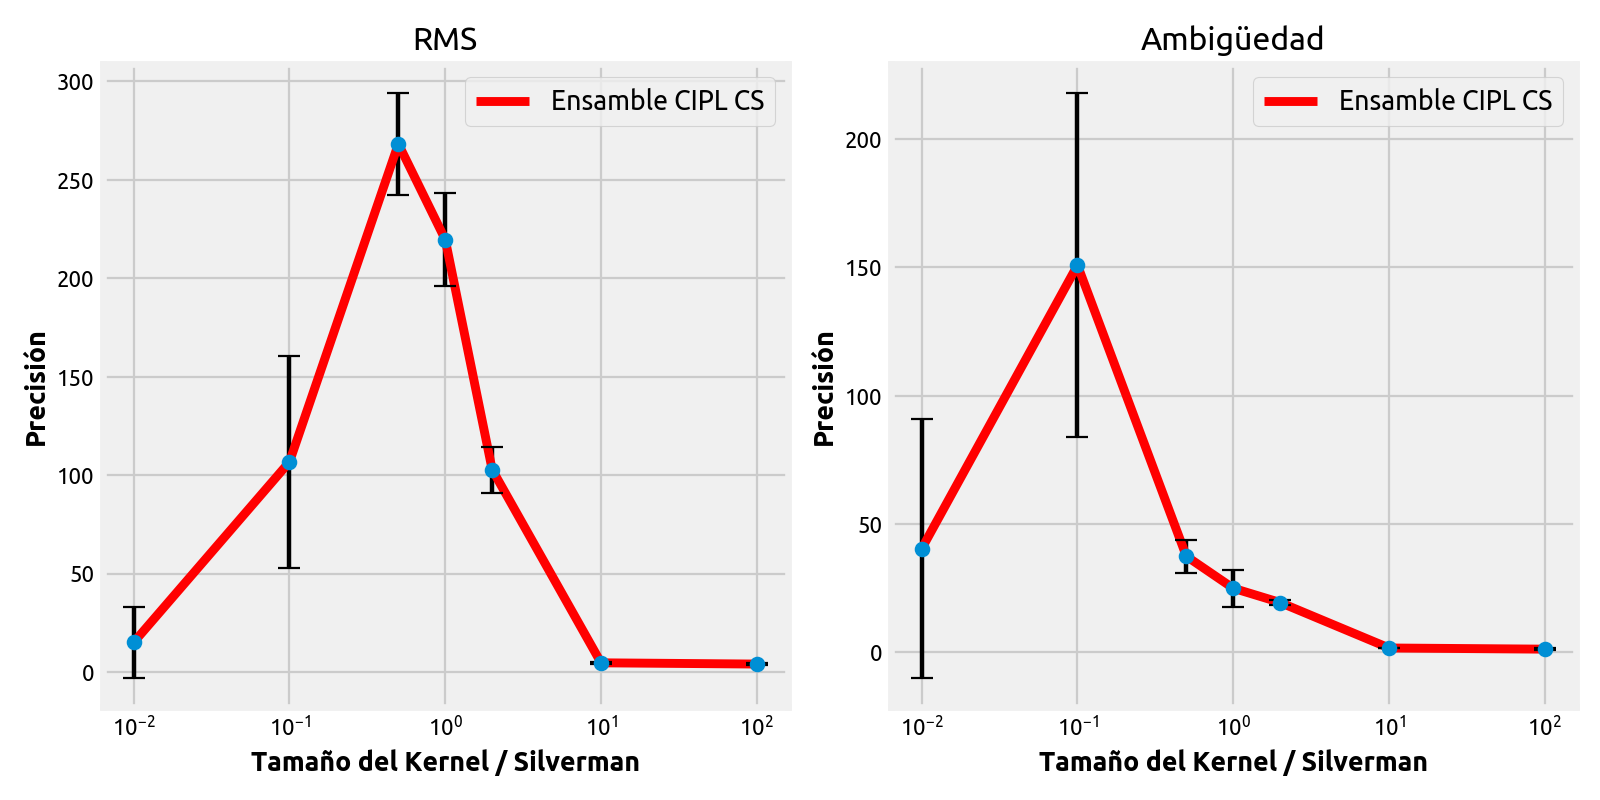

<IPython.core.display.Javascript object>


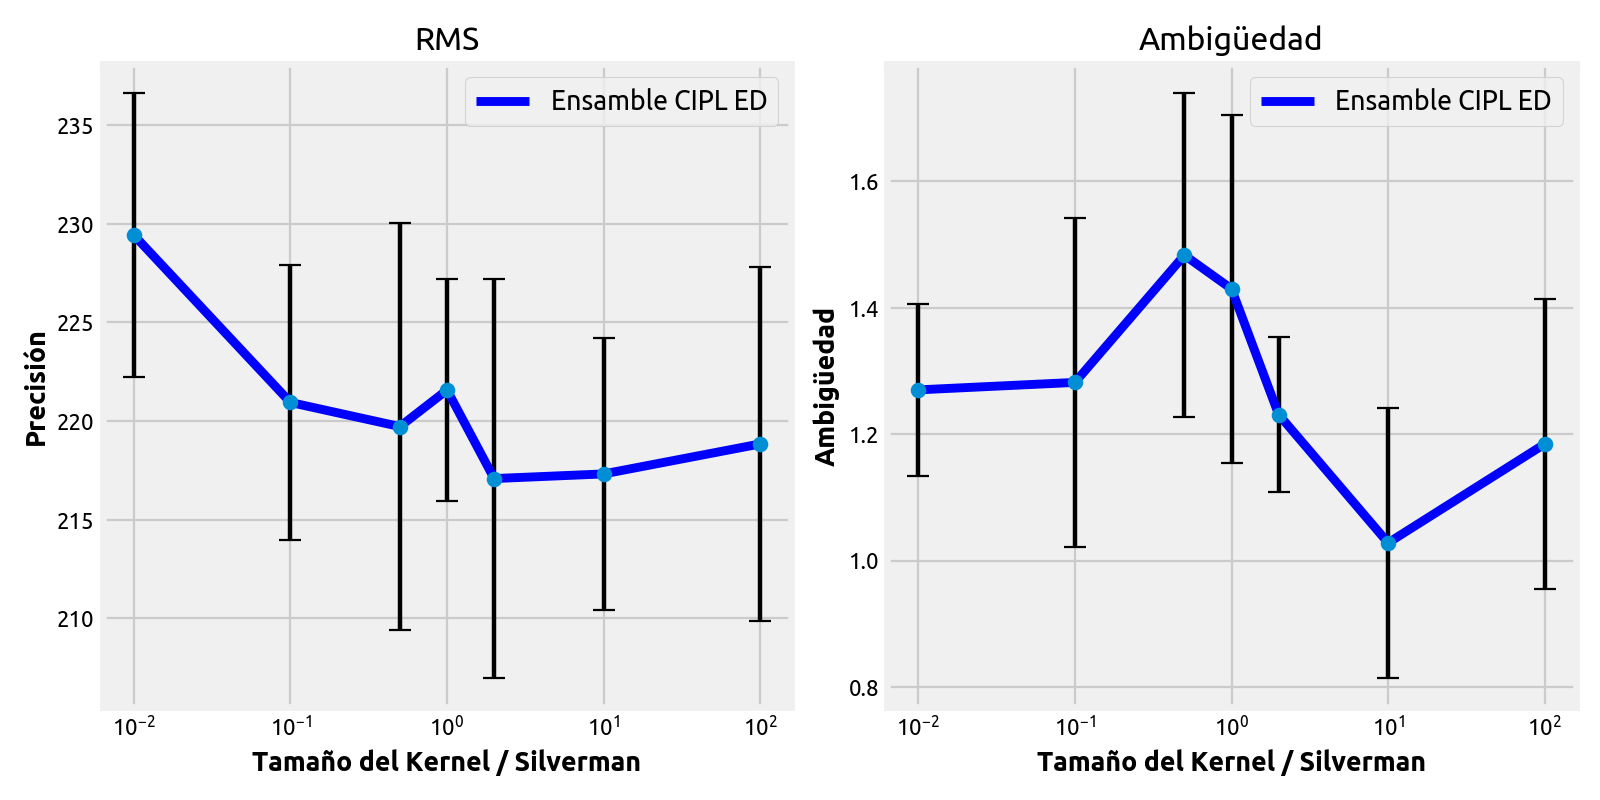

In [85]:
score_s_cs = np.array(score_s_cs)
diversity_s_cs = np.array(diversity_s_cs)
score_s_ed = np.array(score_s_ed)
diversity_s_ed = np.array(diversity_s_ed)

f = plt.figure(figsize=(10,5), dpi=80)
plt.subplot(121)
plt.plot(ns, score_s_cs[:, 0], '-r', label='Ensamble CIPL CS')
plt.errorbar(ns, score_s_cs[:, 0], score_s_cs[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('RMS')
plt.xlabel('Tamaño del Kernel / Silverman')
plt.ylabel('Precisión')
plt.xscale('log')
plt.subplot(122)
plt.plot(ns, diversity_s_cs[:, 0], '-r', label='Ensamble CIPL CS')
plt.errorbar(ns, diversity_s_cs[:, 0], diversity_s_cs[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Ambigüedad')
plt.xlabel('Tamaño del Kernel / Silverman')
plt.ylabel('Precisión')
plt.xscale('log')
plt.tight_layout()

f = plt.figure(figsize=(10,5), dpi=80)
plt.subplot(121)
plt.plot(ns, score_s_ed[:, 0], '-b', label='Ensamble CIPL ED')
plt.errorbar(ns, score_s_ed[:, 0], score_s_ed[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('RMS')
plt.xlabel('Tamaño del Kernel / Silverman')
plt.ylabel('Precisión')
plt.xscale('log')
plt.subplot(122)
plt.plot(ns, diversity_s_ed[:, 0], '-b', label='Ensamble CIPL ED')
plt.errorbar(ns, diversity_s_ed[:, 0], diversity_s_ed[:, 1], linestyle='None', marker='o', lw=2, ecolor='k', capsize=5)
plt.legend()
plt.title('Ambigüedad')
plt.xlabel('Tamaño del Kernel / Silverman')
plt.ylabel('Ambigüedad')
plt.xscale('log')

plt.tight_layout()

plt.show()

In [78]:
model_cs = get_ensemble_cip_cs(0.5, s)
model_cs.fit(X_train, y_train, **args_train_cip)

Comienza la compilación Ensamble CIPL CS  - elapsed: 14.68 [s]
Ensamble CIPL CS - fold: 1, epoch:[####################] 500/500 elapsed: 15.57[s] - left: 0.00[s] | score: 1387.1071 / 1085.5605


In [79]:
model_ed = get_ensemble_cip_ed(0.5, s)
model_ed.fit(X_train, y_train, **args_train_cip)

Comienza la compilación Ensamble CIPL ED  - elapsed: 15.47 [s]
Ensamble CIPL ED - fold: 1, epoch:[####################] 500/500 elapsed: 13.46[s] - left: 0.00[s] | score: 8.1628 / 9.3398


In [80]:
noise = [n for n in np.linspace(0.01, 1, 10)]
score_snr_cs = []
score_snr_ed = []
score_snr_ncl = []
score_snr_en = []
score_snr_mlp = []
SNR = []
N = X_test.shape[0]
F = X_test.shape[1]
mu = 0.2

for n in noise:
    ne = np.random.randn(N, F) * n + mu
    z1 = X_test + ne
    score_snr_cs.append(model_cs.score(z1, y_test))
    score_snr_ed.append(model_ed.score(z1, y_test))
    score_snr_ncl.append(ensembleNCL.score(z1, y_test))
    score_snr_en.append(ensemble.score(z1, y_test))
    score_snr_mlp.append(mlp.score(z1, y_test))
    SNR.append(np.var(X_test) / np.var(ne))

<IPython.core.display.Javascript object>


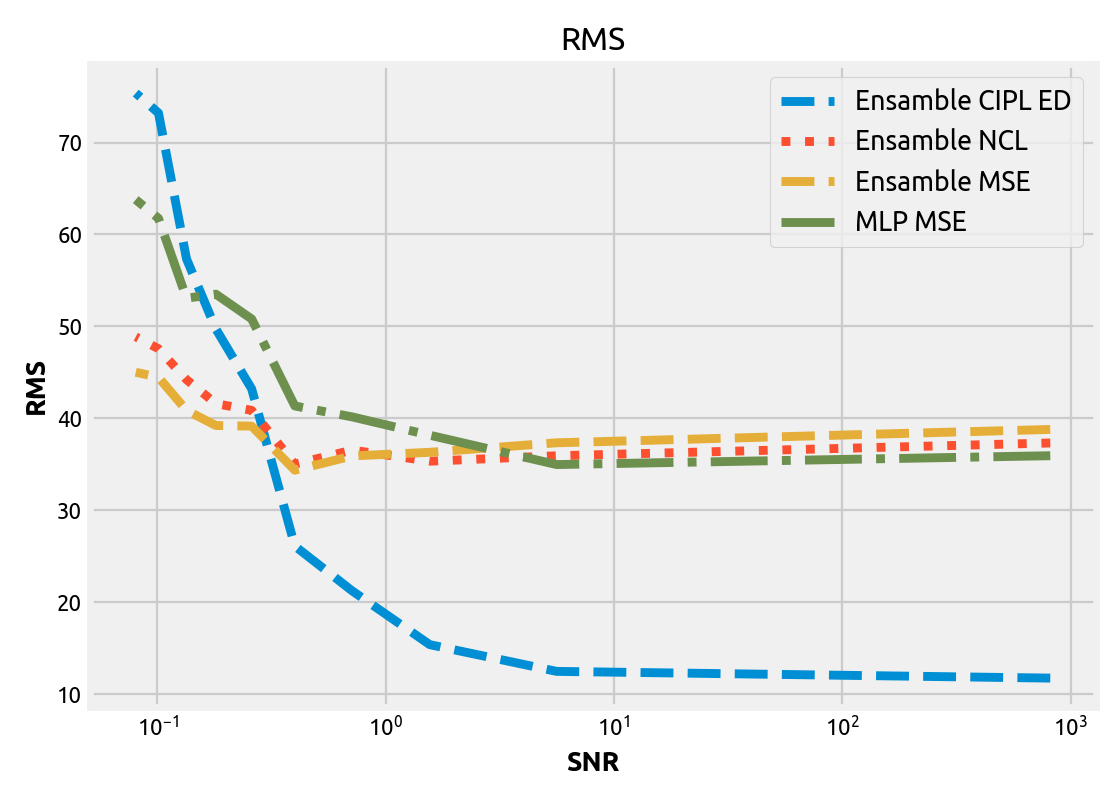

In [86]:
f = plt.figure(figsize=(7,5), dpi=80)
# plt.plot(SNR, score_snr_cs, linestyle='-', label='Ensamble CIPL CS')
plt.plot(SNR, score_snr_ed, linestyle='--', label='Ensamble CIPL ED')
plt.plot(SNR, score_snr_ncl, linestyle=':', label='Ensamble NCL')
plt.plot(SNR, score_snr_en, linestyle='--', label='Ensamble MSE')
plt.plot(SNR, score_snr_mlp, linestyle='-.', label='MLP MSE')
plt.xscale('log')
plt.legend(loc='best')
plt.title('RMS')
plt.xlabel('SNR')
plt.ylabel('RMS')
plt.tight_layout()

plt.show()